In [5]:
import pandas as pd
import numpy as np
import quandl
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
from math import sqrt
import time
import itertools
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.layers.recurrent import LSTM, RNN, GRU, SimpleRNN
from keras.models import load_model
import keras
import h5py
import requests
import os

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

quandl.ApiConfig.api_key = "zFtyXTJz6DTqqdvEy2gi"

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
#Stock Data (DBA and WEAT not available from here)
#data = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'close'] }, ticker = ['DBA'], date = { 'gte': '2012-01-01', 'lte': '2018-04-13' })

### Futures: Continuous contracts (W# - contract # ahead)

In [7]:
#continuous futures W1 is front month
#W1 may18 prices start 3/15/18..futures trade until biz day before 15th of settle month
#data = quandl.get('CHRIS/CME_KW1')
#data.to_csv('CME_KW1.csv')

In [8]:
#data.head()

### Futures: Individual contracts (all data)

In [9]:
#individual contract (July 2018)
#data = quandl.get('CME/WN2018')
#data = quandl.get('CME/WK2018')  #may2018'
#data = quandl.get('CME/WH2018')  #mar2018


In [10]:
#data.iloc[635:,[3]]

### Combining the Financial data sets by Date

In [11]:
# dat = pd.read_csv("Data/CME_W4.csv")
# dat = dat.rename(index=str, columns={'Volume': 'Vol', 'Previous Day Open Interest': 'OpIntPvD'})
# print(dat.head())
# print(len(dat))
# dat.dtypes

# i = 1
# cols = ['Date', 'Open', 'High', 'Low', 'Last', 'Vol', 'OpInt']
# dat = dat[cols]
# cols2 = ['W'+str(i) + "_" + x for x in cols[1:]]
# cols2.insert(0,'Date')
# dat.columns = cols2
# dat.head()

# Import, Merge, Clean Data

### Combine all the Futures Contract Data (5 futures files (W1-W5) and 4 stocks )

In [12]:
def fixDate(inDate):
    lst = inDate.split('/')
    if lst[2] < '20':
        lst[2] = '20'+lst[2]
    else:
        lst[2] = '19'+lst[2]
    return '/'.join(lst)
    
import glob

cols = ['Date', 'Open', 'High', 'Low', 'Last', 'Vol', 'OpInt']

#get futures data files, sort by 13th char (digit)
filenamesFUT = glob.glob('./Data/CME_KW*.csv')
filenamesFUT = sorted(filenamesFUT, key=lambda x: x[12])

#for each file, subset/clean columns, join to W1 by date
for file in filenamesFUT:
    lst = file.split('W')
    cNum = int(lst[1][:1])
    df = pd.read_csv(file)
    
    #W1-3 have date without century, add full year
    #if cNum <= 3:
    #df['Date'] = df['Date'].apply(fixDate)
    df['Date'] = pd.to_datetime(df['Date'])
    
    df = df.rename(index=str, columns={'Volume': 'Vol', 'Previous Day Open Interest': 'OpInt'})
    df = df[cols]
    colsTxt = ['KW'+str(cNum) + "_" + x for x in cols[1:]]
    colsTxt.insert(0, 'Date')
    df.columns = colsTxt

    if cNum == 1:
        dat = df
    else:
        dat = dat.merge(df, how='left', on='Date')

### Add Equity data

In [13]:
filenames = glob.glob('./Data/*.csv')
filenamesEQ = [x for x in filenames if x not in filenamesFUT]

colsEQ = ['Date','Close']

for file in filenamesEQ:
    if 'financialALL' not in file and 'imputed' not in file:
        df = pd.read_csv(file, parse_dates=[0])
        df = df[colsEQ]
    
        #extract ticker
        ticker = file.split('/')[2].split('.')[0]

        df.columns = ['Date', ticker]
        
        #merge with futures data
        dat = dat.merge(df, how='left', on='Date')

IndexError: list index out of range

In [327]:
dat.columns

Index(['Date', 'KW1_Open', 'KW1_High', 'KW1_Low', 'KW1_Last', 'KW1_Vol',
       'KW1_OpInt', 'KW3_Open', 'KW3_High', 'KW3_Low', 'KW3_Last', 'KW3_Vol',
       'KW3_OpInt', 'ADM', 'BG', 'WEAT', 'DBA'],
      dtype='object')

In [328]:
#keep only the W3 futures contract (3 months ahead rolling contract)
dat = dat[['Date', 'KW3_Open', 'KW3_High', 'KW3_Low', 'KW3_Last', 'KW3_Vol', 'KW3_OpInt', 'ADM',
     'BG', 'WEAT', 'DBA']]

#change col names
dat.columns = ['Date', 'FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Close', 'FUT_Vol', 'FUT_OpInt', 'ADM',
     'BG', 'WEAT', 'DBA']

dat.head()

,Date,FUT_Open,FUT_High,FUT_Low,FUT_Close,FUT_Vol,FUT_OpInt,ADM,BG,WEAT,DBA
0,1976-04-09,389.5,389.50,387.00,388.00,95,480,NaN,NaN,NaN,NaN
1,1976-04-12,384.0,385.00,383.00,383.50,115,580,NaN,NaN,NaN,NaN
2,1976-04-13,383.0,383.00,381.00,381.00,5,585,NaN,NaN,NaN,NaN
3,1976-04-14,384.0,384.25,381.75,381.75,55,635,NaN,NaN,NaN,NaN
4,1976-04-15,381.5,394.50,381.50,390.00,230,645,NaN,NaN,NaN,NaN


In [329]:
# make Date the index
dat = dat.set_index('Date')

#save to csv
dat.to_csv("./Data/financialALL.csv")

### Split data into 3 datasets (futures, stocks, weather)

In [47]:
dat = pd.read_csv("Data/financialALL.csv", index_col=0)

In [49]:
dat.columns

Index(['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Close', 'FUT_Vol', 'FUT_OpInt',
       'ADM', 'BG', 'WEAT', 'DBA'],
      dtype='object')

In [50]:
futures = dat[['FUT_Open','FUT_High','FUT_Low','FUT_Close','FUT_Vol','FUT_OpInt']]
stocks = dat[['ADM','BG','WEAT','DBA']]
stocks.dropna(inplace=True)

In [51]:
weather = pd.read_csv("./Data/final_weather_imputed.csv", header=0)
weather['Date'] = pd.to_datetime(weather['day'])
weather.drop(columns=['day'], inplace=True)
weather.set_index('Date', inplace=True)
weather.head()

,1F0_avg_rh,1F0_avg_wind_drct,1F0_avg_wind_speed_kts,1F0_climo_high_f,1F0_climo_low_f,1F0_climo_precip_in,1F0_max_dewpoint_f,1F0_max_rh,1F0_max_temp_f,1F0_min_dewpoint_f,...,WWR_climo_precip_in,WWR_max_dewpoint_f,WWR_max_rh,WWR_max_temp_f,WWR_min_dewpoint_f,WWR_min_rh,WWR_min_temp_f,WWR_precip_in,WWR_snow_in,WWR_snowd_in
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,88.6985,4.95102,3.557650,54.7,32.5,0.06,37.0,100.0,43.0,37.0,...,0.03,34.0,100.0000,37.0,30.0,86.6944,30.0,0.08,1.361442,1.713048
2005-02-01,85.1454,30.55420,5.152340,54.9,32.6,0.07,39.0,100.0,43.0,37.0,...,0.03,34.0,100.0000,36.0,34.0,80.5077,34.0,0.00,1.068212,2.398019
2005-02-02,86.7985,355.15000,3.563940,55.0,32.8,0.08,37.0,100.0,43.0,34.0,...,0.02,34.0,100.0000,46.0,30.0,60.7869,30.0,0.00,0.247806,0.096416
2005-02-03,73.9092,351.57600,1.132680,55.2,33.0,0.06,36.0,100.0,55.0,28.0,...,0.03,37.0,92.9165,61.0,30.0,28.7724,30.0,0.00,-0.790440,-1.163829
2005-02-04,69.7364,211.26100,0.581704,55.4,33.2,0.07,37.0,100.0,59.0,28.0,...,0.03,34.0,93.0280,63.0,34.0,25.3208,34.0,0.00,-0.350570,-0.533856


# Feature Engineering

### OHLC Average

Many traders believe in technical analysis, forecasting prices by analyzing statistics based on trading activity. One particular metric watched is the OHLC average which is the average of the Open, High, Low, and Closing prices of a security. 

In [52]:
#add OHLC for each of the futures contracts row
futures['FUT_OHLC'] = np.sum(futures[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Close']],axis=1) / 4

### Moving Averages

In [53]:
MoveAvg = [50,100,200]
for ma in MoveAvg:
    #add MA columns by taking the mean over specificed window size
    futures['FUT_{}MA'.format(ma)] = futures['FUT_Close'].rolling(window=ma).mean()

### Percent Change

In [54]:
futures['FUT_%Chg'] = futures['FUT_Close'].pct_change()

### Closing price one month ahead (will be the label)

In [55]:
windowSize = 44  #number of days in a month to window data
lookAhead = 22
futures['FUT_CloseAhead'] = futures['FUT_Close'].shift(-lookAhead)  #**** update col selection below as well
futures.dropna(inplace=True)

#moving FUT_Close to 2nd to last col
#futures = futures[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt',
#       'FUT_OHLC', 'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close']]

#uncomment and comment above if adding CloseAhead
futures = futures[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt',
        'FUT_OHLC', 'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close','FUT_CloseAhead']]

### Normalize the data  (call function for whichever cols we want to normalize)

3 datasets after this section are:
<ul>
<li>fut_norm
<li>weather_norm
<li>stk_norm
</ul>

In [56]:
def normalizeData(data):
    minMax = MinMaxScaler()
    normData = minMax.fit_transform(data.values.reshape(-1,1)).ravel()
    return normData

In [57]:
#normalize futures data (except the close)
fut_norm = futures.iloc[:,:-1].apply(normalizeData, axis=0)

#do close separately so can use model later to denorm
close_normalizer = MinMaxScaler()
#fut_norm['FUT_Close'] = close_normalizer.fit_transform(futures.iloc[:,-1].values.reshape(-1,1)).ravel()
fut_norm['FUT_CloseAhead'] = close_normalizer.fit_transform(futures.iloc[:,-1].values.reshape(-1,1)).ravel()

In [58]:
weather.head()

,1F0_avg_rh,1F0_avg_wind_drct,1F0_avg_wind_speed_kts,1F0_climo_high_f,1F0_climo_low_f,1F0_climo_precip_in,1F0_max_dewpoint_f,1F0_max_rh,1F0_max_temp_f,1F0_min_dewpoint_f,...,WWR_climo_precip_in,WWR_max_dewpoint_f,WWR_max_rh,WWR_max_temp_f,WWR_min_dewpoint_f,WWR_min_rh,WWR_min_temp_f,WWR_precip_in,WWR_snow_in,WWR_snowd_in
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,88.6985,4.95102,3.557650,54.7,32.5,0.06,37.0,100.0,43.0,37.0,...,0.03,34.0,100.0000,37.0,30.0,86.6944,30.0,0.08,1.361442,1.713048
2005-02-01,85.1454,30.55420,5.152340,54.9,32.6,0.07,39.0,100.0,43.0,37.0,...,0.03,34.0,100.0000,36.0,34.0,80.5077,34.0,0.00,1.068212,2.398019
2005-02-02,86.7985,355.15000,3.563940,55.0,32.8,0.08,37.0,100.0,43.0,34.0,...,0.02,34.0,100.0000,46.0,30.0,60.7869,30.0,0.00,0.247806,0.096416
2005-02-03,73.9092,351.57600,1.132680,55.2,33.0,0.06,36.0,100.0,55.0,28.0,...,0.03,37.0,92.9165,61.0,30.0,28.7724,30.0,0.00,-0.790440,-1.163829
2005-02-04,69.7364,211.26100,0.581704,55.4,33.2,0.07,37.0,100.0,59.0,28.0,...,0.03,34.0,93.0280,63.0,34.0,25.3208,34.0,0.00,-0.350570,-0.533856


In [59]:
#normalize stock and weather data
stk_norm = stocks.iloc[:,:].apply(normalizeData, axis=0)
weather_norm = weather.iloc[:,:].apply(normalizeData, axis=0)

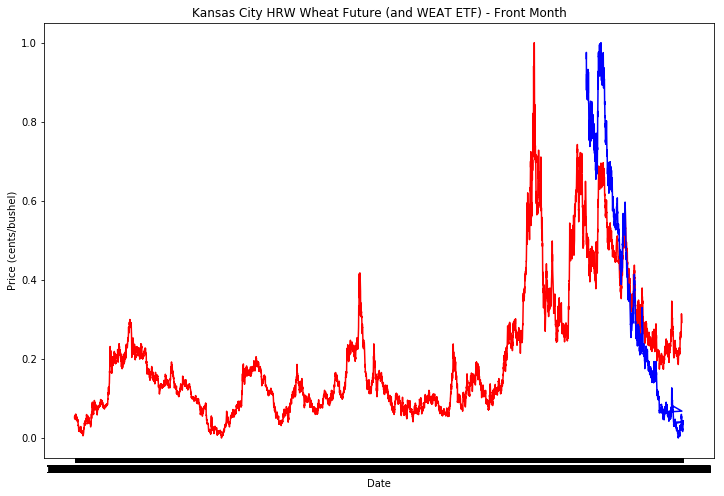

In [60]:
plt.figure(figsize=(12,8))
plt.plot(fut_norm['FUT_Close'], color='r', label='W1')
plt.plot(stk_norm['WEAT'], color='b')
plt.xlabel('Date')
plt.ylabel('Price (cents/bushel)')
plt.title('Kansas City HRW Wheat Future (and WEAT ETF) - Front Month');

### Prep Data for NN

3 datasets (pre-windowing)
<ul>
<li>fut_norm
<li>fut_weather_norm
<li>fut_weatherLen_norm (futures only but weathersLength)
<li>fut_stk_weather_norm
<li>fut_stkLen_weatherLen_norm (futures only but stockLength)
<li>fut_stkLen_weather_norm (futures & weather only but stockLength)
</ul>

In [64]:
fut_norm.head()

,FUT_Open,FUT_High,FUT_Low,FUT_Vol,FUT_OpInt,FUT_OHLC,FUT_50MA,FUT_100MA,FUT_200MA,FUT_%Chg,FUT_Close,FUT_CloseAhead
Date,,,,,,,,,,,,
1977-01-25,0.056070,0.051546,0.054634,0.033855,0.197008,0.053501,0.047188,0.070794,0.129900,0.646660,0.052996,0.056338
1977-01-26,0.051682,0.048500,0.050732,0.017733,0.196418,0.050063,0.047523,0.070033,0.129138,0.643435,0.050609,0.052041
1977-01-27,0.052657,0.048969,0.051220,0.016121,0.195975,0.050305,0.047805,0.069187,0.128402,0.661408,0.049654,0.050847
1977-01-28,0.051438,0.047095,0.049512,0.033586,0.195336,0.048857,0.047949,0.068359,0.127677,0.661365,0.048699,0.047505
1977-01-31,0.051195,0.047329,0.050976,0.025928,0.192580,0.049581,0.048177,0.067409,0.126957,0.691936,0.050131,0.047744


In [65]:
fut_weather_norm = weather_norm.merge(fut_norm, left_index=True, right_index=True)
fut_weatherLen_norm = fut_weather_norm[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt', 'FUT_OHLC',
       'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close', 'FUT_CloseAhead']]
# fut_weatherLen_norm = fut_weather_norm[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt', 'FUT_OHLC',
#        'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close']]

In [66]:
len(fut_weather_norm)

3272

In [67]:
fut_stk_weather_norm = stk_norm.merge(fut_weather_norm, left_index=True, right_index=True)
fut_stkLen_weatherLen_norm = fut_stk_weather_norm[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt', 'FUT_OHLC',
       'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close', 'FUT_CloseAhead']]
# fut_stkLen_weatherLen_norm = fut_stk_weather_norm[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt', 'FUT_OHLC',
#        'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close']]
fut_stkLen_weather_norm = fut_stk_weather_norm.drop(columns=['ADM','BG','DBA','WEAT'])

In [68]:
#creates the windowed data
def prepDataValid(df, window=30):
    
    newData = []

    data = df.as_matrix()
    
    for i in range(len(data) - window): 
        newData.append(data[i: i + (window+1)]) # moving window of data, add one as index starts at 0
    
    
    newData = np.array(newData)
    split = int(round(len(newData)/3))
    
    XTrain = newData[:split, :-1]    # data for days d in a month
    yTrain = newData[:split,-1][:,-1] # data for day  d+1 only last col (FUT_CloseAhead)
    
    XValid = newData[split:(2*split),:-1]
    yValid = newData[split:(2*split),-1][:,-1]
    
    XTest = newData[(2*split):,:-1]
    yTest = newData[(2*split):,-1][:,-1]

    return [XTrain, yTrain, XValid, yValid, XTest, yTest]

In [69]:
#creates the windowed data
def prepData(df, window=30):
    
    newData = []

    data = df.as_matrix()
    
    for i in range(len(data) - window): 
        newData.append(data[i: i + (window+1)]) # moving window of data, add one as index starts at 0
    
    newData = np.array(newData)
    split = int(round(len(newData)/3))

    XTrain = newData[:(2*split), :-1]    # data for days d in a month
    yTrain = newData[:(2*split),-1][:,-1] # data for day  d+1 only last col (FUT_CloseAhead)
    
    #XValid = newData[split:(2*split),:-1]
    #yValid = newData[split:(2*split),-1][:,-1]
    
    XTest = newData[(2*split):,:-1]
    yTest = newData[(2*split):,-1][:,-1]

    return [XTrain, yTrain, XTest, yTest]

In [70]:
#sets up non-windowing data base NN (assumes last col is target)
def prepDataBase(df):
    split = int(round(len(df)/3))
    df = np.array(df)
    XTrain = df[:(2*split), :-1]    # first split of rows, all but last col
    yTrain = df[:(2*split),-1]      # only last col
    
    #XValid = df[split:(2*split),:-1]
    #yValid = df[split:(2*split),-1]
    
    XTest = df[(2*split):,:-1]
    yTest = df[(2*split):,-1]
    
    return [XTrain, yTrain, XTest, yTest]

In [71]:
# #sets up non-windowing data base NN (assumes last col is target)
# def prepDataBase(df):
#     split = int(round(len(df)/3))
#     df = np.array(df)
#     XTrain = df[:split, :-1]    # first split of rows, all but last col
#     yTrain = df[:split,-1]      # only last col
    
#     XValid = df[split:(2*split),:-1]
#     yValid = df[split:(2*split),-1]
    
#     XTest = df[(2*split):,:-1]
#     yTest = df[(2*split):,-1]
    
#     return [XTrain, yTrain, XValid, yValid, XTest, yTest]

# Windowing of Data 

predData() returns RNN ready data: 
<ul>
<li>XTrain
<li>yTrain
<li>XValid
<li>yValid
<li>XTest
<li>yTest
</ul>

In [72]:
#get data split to do validation
#just futures data (back to 1976)
XTrainF, yTrainF, XValidF, yValidF, XTestF, yTestF = prepDataValid(fut_norm, windowSize)
XTrainFW, yTrainFW, XValidFW, yValidFW, XTestFW, yTestFW = prepDataValid(fut_weather_norm, windowSize)
XTrainFSW, yTrainFSW, XValidFSW, yValidFSW, XTestFSW, yTestFSW = prepDataValid(fut_stk_weather_norm, windowSize)

In [73]:
# get the non-windowed data for baseline NN
XTrainF_Base, yTrainF_Base, XTestF_Base, yTestF_Base = prepDataBase(fut_norm)
XTrainFW_Base, yTrainFW_Base, XTestFW_Base, yTestFW_Base = prepDataBase(fut_weather_norm)
XTrainFW_F_Base, yTrainFW_F_Base, XTestFW_F_Base, yTestFW_F_Base = prepDataBase(fut_weatherLen_norm)
XTrainFSW_Base, yTrainFSW_Base, XTestFSW_Base, yTestFSW_Base = prepDataBase(fut_stk_weather_norm)
XTrainFSW_F_Base, yTrainFSW_F_Base, XTestFSW_F_Base, yTestFSW_F_Base = prepDataBase(fut_stkLen_weatherLen_norm)
XTrainFSW_FW_Base, yTrainFSW_FW_Base, XTestFSW_FW_Base, yTestFSW_FW_Base = prepDataBase(fut_stkLen_weather_norm)


In [74]:
## >>>>> label is FUT_CloseAhead (close price 22 days forward)  ... should we just use FUT_Close?

#just futures data (back to 1976)
XTrainF, yTrainF, XTestF, yTestF = prepData(fut_norm, windowSize)

#futures and weather (back to 2005)
XTrainFW, yTrainFW, XTestFW, yTestFW = prepData(fut_weather_norm, windowSize)
XTrainFW_F, yTrainFW_F, XTestFW_F, yTestFW_F = prepData(fut_weatherLen_norm, windowSize)

#futures, weather, and stocks (back to 2011)
XTrainFSW, yTrainFSW, XTestFSW, yTestFSW = prepData(fut_stk_weather_norm, windowSize)
XTrainFSW_F, yTrainFSW_F, XTestFSW_F, yTestFSW_F = prepData(fut_stkLen_weatherLen_norm, windowSize)
XTrainFSW_FW, yTrainFSW_FW, XTestFSW_FW, yTestFSW_FW = prepData(fut_stkLen_weather_norm, windowSize)

### Check if shapes look ok

In [75]:
print(XTrainFSW_Base.shape)

(1068, 1410)


In [76]:
print(XTrainF.shape, yTrainF.shape, XTestF.shape, yTestF.shape)

(6880, 44, 12) (6880,) (3440, 44, 12) (3440,)


In [77]:
fut_norm.columns

Index(['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt', 'FUT_OHLC',
       'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close',
       'FUT_CloseAhead'],
      dtype='object')

In [78]:
print(XTrainFW.shape, yTrainFW.shape, XTestFW.shape, yTestFW.shape)

(2152, 44, 1407) (2152,) (1076, 44, 1407) (1076,)


In [79]:
print(XTrainFSW.shape, yTrainFSW.shape, XTestFSW.shape, yTestFSW.shape)

(1038, 44, 1411) (1038,) (520, 44, 1411) (520,)


# Neural Network (RNN, GRU, LSTM)

In [80]:
#default layers = 6, neurons list always should equal 6
def build_NN(inShape, neuronList, rnnLayers=2, nnType='RNN'):
    
    model = Sequential()
    #model.add(Dense(neuronList[0], input_shape=(inShape[0], inShape[1])))  #input layer
    
    #print(inShape[1], rnnLayers, neuronList)
    if nnType == 'RNN':
        model.add(Dense(neuronList[0], input_shape=(inShape[0], inShape[1])))  #input layer
        for i in range(rnnLayers):
            if i != rnnLayers-1:
                model.add(SimpleRNN(neuronList[1], return_sequences=True))
            else:
                model.add(SimpleRNN(neuronList[2]))
        model.add(Dense(neuronList[3], activation='relu'))
        model.add(Dense(neuronList[4], activation='relu'))
    elif nnType == 'GRU':
        model.add(Dense(neuronList[0], input_shape=(inShape[0], inShape[1])))  #input layer
        for i in range(rnnLayers):
            if i != rnnLayers-1:
                model.add(GRU(neuronList[1], return_sequences=True))
            else:
                model.add(GRU(neuronList[2]))
        model.add(Dense(neuronList[3], activation='relu'))
        model.add(Dense(neuronList[4], activation='relu'))
    elif nnType == 'LSTM':
        model.add(Dense(neuronList[0], input_shape=(inShape[0], inShape[1])))  #input layer
        for i in range(rnnLayers):
            if i != rnnLayers-1:
                model.add(LSTM(neuronList[1], return_sequences=True)) 
            else:
                model.add(LSTM(neuronList[2]))
        model.add(Dense(neuronList[3], activation='relu'))      
        model.add(Dense(neuronList[4], activation='relu'))
    elif nnType == 'BASE':
        model.add(Dense(neuronList[0], input_shape=(inShape[1]-1,)))  #input layer
        for i in range(rnnLayers):
            if i != rnnLayers-1:
                model.add(Dense(neuronList[1], activation='relu'))
            else:
                model.add(Dense(neuronList[2], activation='relu'))
        model.add(Dense(neuronList[3], activation='relu'))
        model.add(Reshape((-1,)))
        model.add(Dense(neuronList[4], activation='relu'))
    else:
        print('should not be here')
    
    model.add(Dense(neuronList[5], activation='linear', kernel_initializer="uniform")) #output layer
      
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    #model.summary() 

    return model

### Build Models for each dataset and type of NN

In [81]:
#get the input shapes for each dataset to use input layer of NN model
inShapeF = [windowSize, len(fut_norm.columns)]
inShapeFW = [windowSize, len(fut_weather_norm.columns)]
inShapeFSW = [windowSize, len(fut_stk_weather_norm.columns)]

### Validation

In [ ]:
neuronsList = [[512, 256, 256, 64, 32, 1],[1024, 512, 512, 128, 64, 1], [256, 128, 128, 32, 16, 1]]
layersList = [2,4,6]
epochs = 8
batchSize = 1000

scoreTable = []
score = []

for layers in layersList:
    for neurons in neuronsList:
        modelLSTM_F = build_NN(inShapeF, neurons, rnnLayers=layers, nnType='LSTM')
        modelLSTM_FW = build_NN(inShapeFW, neurons, rnnLayers=layers, nnType='LSTM')
        modelLSTM_FSW = build_NN(inShapeFSW, neurons, rnnLayers=layers, nnType='LSTM')
        
        modelLSTM_F.fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, verbose=1)
        modelLSTM_FW.fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, verbose=1)
        modelLSTM_FSW.fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, verbose=1)
        
        temp = []
        temp.append(modelLSTM_F.evaluate(XValidF, yValidF, verbose=0)[0])
        temp.append(modelLSTM_FW.evaluate(XValidFW, yValidFW, verbose=0)[0])
        temp.append(modelLSTM_FSW.evaluate(XValidFSW, yValidFSW, verbose=0)[0])
        
        score.append(np.mean(temp))
    
    scoreTable.append(score)
    score = []
    

Epoch 1/8
6880/6880 [==============================] - 35s 5ms/step - loss: 0.0081 - acc: 1.4535e-04
Epoch 2/8
6880/6880 [==============================] - 33s 5ms/step - loss: 0.0027 - acc: 1.4535e-04
Epoch 3/8
6880/6880 [==============================] - 33s 5ms/step - loss: 0.0013 - acc: 1.4535e-04
Epoch 4/8
6880/6880 [==============================] - 33s 5ms/step - loss: 7.4131e-04 - acc: 1.4535e-04
Epoch 5/8
6880/6880 [==============================] - 33s 5ms/step - loss: 6.4187e-04 - acc: 1.4535e-04
Epoch 6/8
6880/6880 [==============================] - 33s 5ms/step - loss: 5.4077e-04 - acc: 1.4535e-04
Epoch 7/8
6880/6880 [==============================] - 32s 5ms/step - loss: 4.9628e-04 - acc: 1.4535e-04
Epoch 8/8
6880/6880 [==============================] - 32s 5ms/step - loss: 4.4503e-04 - acc: 1.4535e-04
Epoch 1/8
2152/2152 [==============================] - 14s 7ms/step - loss: 0.1291 - acc: 0.0000e+00
Epoch 2/8
2152/2152 [==============================] - 13s 6ms/step - l

2152/2152 [==============================] - 26s 12ms/step - loss: 0.1852 - acc: 0.0000e+00
Epoch 2/8
2152/2152 [==============================] - 23s 11ms/step - loss: 0.0390 - acc: 0.0000e+00
Epoch 3/8
2152/2152 [==============================] - 23s 10ms/step - loss: 0.0322 - acc: 0.0000e+00
Epoch 4/8
2152/2152 [==============================] - 22s 10ms/step - loss: 0.0340 - acc: 0.0000e+00
Epoch 5/8
2152/2152 [==============================] - 23s 11ms/step - loss: 0.0313 - acc: 0.0000e+00
Epoch 6/8
2152/2152 [==============================] - 25s 12ms/step - loss: 0.0322 - acc: 0.0000e+00
Epoch 7/8
2152/2152 [==============================] - 23s 11ms/step - loss: 0.0310 - acc: 0.0000e+00
Epoch 8/8
2152/2152 [==============================] - 23s 11ms/step - loss: 0.0317 - acc: 0.0000e+00
Epoch 1/8
1038/1038 [==============================] - 14s 14ms/step - loss: 0.1964 - acc: 0.0000e+00
Epoch 2/8
1038/1038 [==============================] - 11s 11ms/step - loss: 0.0330 - acc: 0

### Get the bestLayers and bestNeurons from 'Grid Search'

In [182]:
scoreTableNP = np.array(scoreTable)
idx = np.where(scoreTableNP == np.min(scoreTableNP))

bestLayers = np.array(layersList)[idx[0]][0]
bestNeurons = np.array(neuronsList)[idx[1]][0]

In [388]:
list(bestNeurons)

[256, 128, 128, 32, 16, 1]

In [390]:
#neurons list
#neurons = [512, 256, 256, 64, 32, 1]
neurons2 = list(bestNeurons)
neurons = [256, 256, 128, 32, 16, 1]  #NN doesn't like 128 as 2nd neuron value
epochs = 10
batchSize = 300
bestLayers = 4

In [313]:
modelBASE_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='BASE')
modelBASE_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='BASE')
modelBASE_FW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='BASE')
modelBASE_FSW = build_NN(inShapeFSW, neurons, rnnLayers=bestLayers, nnType='BASE')
modelBASE_FSW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='BASE')
modelBASE_FSW_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='BASE')

In [391]:
modelBASE_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='BASE')
modelRNN_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='RNN')
modelGRU_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='GRU')
modelLSTM_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='LSTM')

#Futures & Weather
modelBASE_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='BASE')
modelRNN_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='RNN')
modelGRU_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='GRU')
modelLSTM_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='LSTM')

#Futures only but Weather length
modelBASE_FW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='BASE')
modelRNN_FW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='RNN')
modelGRU_FW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='GRU')
modelLSTM_FW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='LSTM')


# Futures & Stock & Weather
modelBASE_FSW = build_NN(inShapeFSW, neurons, rnnLayers=bestLayers, nnType='BASE')
modelRNN_FSW = build_NN(inShapeFSW, neurons, rnnLayers=bestLayers, nnType='RNN')
modelGRU_FSW = build_NN(inShapeFSW, neurons, rnnLayers=bestLayers, nnType='GRU')
modelLSTM_FSW = build_NN(inShapeFSW, neurons, rnnLayers=bestLayers, nnType='LSTM')

#Futures only but stock length
modelBASE_FSW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='BASE')
modelRNN_FSW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='RNN')
modelGRU_FSW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='GRU')
modelLSTM_FSW_F = build_NN(inShapeF, neurons, rnnLayers=bestLayers, nnType='LSTM')

#Futures & weather only but stock length
modelBASE_FSW_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='BASE')
modelRNN_FSW_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='RNN')
modelGRU_FSW_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='GRU')
modelLSTM_FSW_FW = build_NN(inShapeFW, neurons, rnnLayers=bestLayers, nnType='LSTM')

print(modelBASE_F.summary(),'\n')
print(modelRNN_F.summary(),'\n')
print(modelGRU_F.summary(),'\n')
print(modelLSTM_F.summary(),'\n')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_921 (Dense)            (None, 256)               3072      
_________________________________________________________________
dense_922 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_923 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_924 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_925 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_926 (Dense)            (None, 32)                4128      
_________________________________________________________________
reshape_31 (Reshape)         (None, 32)                0         
__________

In [392]:
#get the loss
def model_traintest_loss(mod, XTrain, yTrain, XTest, yTest):
    trainLoss = mod.evaluate(XTrain, yTrain, verbose=0)
    testLoss = mod.evaluate(XTest, yTest, verbose=0)
    print('Train Score: {:.5f} MSE ({:.2f} RMSE)'.format(trainLoss[0], math.sqrt(trainLoss[0])))
    print('Test Score: {:.5f} MSE ({:.2f} RMSE)'.format(testLoss[0], math.sqrt(testLoss[0])))
    return trainLoss[0], testLoss[0]

def model_loss(mod, X, y):
    loss = mod.evaluate(X, y, verbose=0)
    #print('Train Score: {:.5f} MSE ({:.2f} RMSE)'.format(trainLoss[0], math.sqrt(trainLoss[0])))
    #print('Test Score: {:.5f} MSE ({:.2f} RMSE)'.format(testLoss[0], math.sqrt(testLoss[0])))
    return loss[0]  #returns MSE

## Fit Models:  Futures

In [393]:
modelBASE_F.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_921 (Dense)            (None, 256)               3072      
_________________________________________________________________
dense_922 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_923 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_924 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_925 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_926 (Dense)            (None, 32)                4128      
_________________________________________________________________
reshape_31 (Reshape)         (None, 32)                0         
__________

In [314]:
# modelBASE_F.fit(XTrainF_Base, yTrainF_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
# modelBASE_FW.fit(XTrainFW_Base, yTrainFW_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
# modelBASE_FW_F.fit(XTrainFW_F_Base, yTrainFW_F_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
# modelBASE_FSW.fit(XTrainFSW_Base, yTrainFSW_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
# modelBASE_FSW_F.fit(XTrainFSW_F_Base, yTrainFSW_F_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
# modelBASE_FSW_FW.fit(XTrainFSW_FW_Base, yTrainFSW_FW_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 5539 samples, validate on 1385 samples
Epoch 1/10
5539/5539 [==============================] - 29s 5ms/step - loss: 0.0082 - acc: 1.8054e-04 - val_loss: 8.2380e-04 - val_acc: 0.0000e+00
Epoch 2/10
5539/5539 [==============================] - 0s 54us/step - loss: 0.0011 - acc: 1.8054e-04 - val_loss: 1.6145e-04 - val_acc: 0.0000e+00
Epoch 3/10
5539/5539 [==============================] - 0s 51us/step - loss: 2.3577e-04 - acc: 1.8054e-04 - val_loss: 1.1604e-04 - val_acc: 0.0000e+00
Epoch 4/10
5539/5539 [==============================] - 0s 59us/step - loss: 1.1785e-04 - acc: 1.8054e-04 - val_loss: 6.5528e-05 - val_acc: 0.0000e+00
Epoch 5/10
5539/5539 [==============================] - 0s 52us/step - loss: 5.6688e-05 - acc: 1.8054e-04 - val_loss: 3.6824e-05 - val_acc: 0.0000e+00
Epoch 6/10
5539/5539 [==============================] - 0s 54us/step - loss: 2.5167e-05 - acc: 1.8054e-04 - val_loss: 1.1780e-05 - val_acc: 0.0000e+00
Epoch 7/10
5539/5539 [==============================] 

Epoch 6/10
854/854 [==============================] - 0s 126us/step - loss: 0.0135 - acc: 0.0000e+00 - val_loss: 0.0336 - val_acc: 0.0000e+00
Epoch 7/10
854/854 [==============================] - 0s 132us/step - loss: 0.0124 - acc: 0.0000e+00 - val_loss: 0.0660 - val_acc: 0.0000e+00
Epoch 8/10
854/854 [==============================] - 0s 126us/step - loss: 0.0116 - acc: 0.0000e+00 - val_loss: 0.0299 - val_acc: 0.0000e+00
Epoch 9/10
854/854 [==============================] - 0s 126us/step - loss: 0.0109 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 10/10
854/854 [==============================] - 0s 133us/step - loss: 0.0102 - acc: 0.0000e+00 - val_loss: 0.0322 - val_acc: 0.0000e+00


In [394]:
%%time
modelBASE_F.fit(XTrainF_Base, yTrainF_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelRNN_F.fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_F.fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_F.fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 5528 samples, validate on 1382 samples
Epoch 1/10
5528/5528 [==============================] - 43s 8ms/step - loss: 0.0080 - acc: 1.8090e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 2/10
5528/5528 [==============================] - 0s 65us/step - loss: 0.0013 - acc: 1.8090e-04 - val_loss: 5.3725e-04 - val_acc: 0.0000e+00
Epoch 3/10
5528/5528 [==============================] - 0s 64us/step - loss: 6.6372e-04 - acc: 1.8090e-04 - val_loss: 5.0898e-04 - val_acc: 0.0000e+00
Epoch 4/10
5528/5528 [==============================] - 0s 63us/step - loss: 5.4174e-04 - acc: 1.8090e-04 - val_loss: 4.5347e-04 - val_acc: 0.0000e+00
Epoch 5/10
5528/5528 [==============================] - 0s 62us/step - loss: 4.8429e-04 - acc: 1.8090e-04 - val_loss: 4.2850e-04 - val_acc: 0.0000e+00
Epoch 6/10
5528/5528 [==============================] - 0s 61us/step - loss: 4.4950e-04 - acc: 1.8090e-04 - val_loss: 4.3480e-04 - val_acc: 0.0000e+00
Epoch 7/10
5528/5528 [==============================] - 0s

## Fit Models:  Futures + Weather data

In [395]:
%%time
modelBASE_FW.fit(XTrainFW_Base, yTrainFW_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelRNN_FW.fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_FW.fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_FW.fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 1745 samples, validate on 437 samples
Epoch 1/10
1745/1745 [==============================] - 55s 31ms/step - loss: 0.1161 - acc: 0.0000e+00 - val_loss: 0.0148 - val_acc: 0.0000e+00
Epoch 2/10
1745/1745 [==============================] - 0s 214us/step - loss: 0.0460 - acc: 0.0000e+00 - val_loss: 0.0389 - val_acc: 0.0000e+00
Epoch 3/10
1745/1745 [==============================] - 0s 207us/step - loss: 0.0375 - acc: 0.0000e+00 - val_loss: 0.0529 - val_acc: 0.0000e+00
Epoch 4/10
1745/1745 [==============================] - 0s 204us/step - loss: 0.0354 - acc: 0.0000e+00 - val_loss: 0.0236 - val_acc: 0.0000e+00
Epoch 5/10
1745/1745 [==============================] - 0s 180us/step - loss: 0.0344 - acc: 0.0000e+00 - val_loss: 0.0309 - val_acc: 0.0000e+00
Epoch 6/10
1745/1745 [==============================] - 1s 329us/step - loss: 0.0336 - acc: 0.0000e+00 - val_loss: 0.0370 - val_acc: 0.0000e+00
Epoch 7/10
1745/1745 [==============================] - 0s 241us/step - loss: 0.0328 - ac

### Futures only (weather length)

In [396]:
%%time
modelBASE_FW_F.fit(XTrainFW_F_Base, yTrainFW_F_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelRNN_FW_F.fit(XTrainFW_F, yTrainFW_F, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_FW_F.fit(XTrainFW_F, yTrainFW_F, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_FW_F.fit(XTrainFW_F, yTrainFW_F, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 1745 samples, validate on 437 samples
Epoch 1/10
1745/1745 [==============================] - 55s 32ms/step - loss: 0.1385 - acc: 0.0000e+00 - val_loss: 0.0623 - val_acc: 0.0000e+00
Epoch 2/10
1745/1745 [==============================] - 0s 106us/step - loss: 0.0289 - acc: 0.0000e+00 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 3/10
1745/1745 [==============================] - 0s 98us/step - loss: 0.0141 - acc: 5.7307e-04 - val_loss: 0.0228 - val_acc: 0.0000e+00
Epoch 4/10
1745/1745 [==============================] - 0s 108us/step - loss: 0.0092 - acc: 5.7307e-04 - val_loss: 0.0114 - val_acc: 0.0000e+00
Epoch 5/10
1745/1745 [==============================] - 0s 117us/step - loss: 0.0087 - acc: 5.7307e-04 - val_loss: 0.0067 - val_acc: 0.0000e+00
Epoch 6/10
1745/1745 [==============================] - 0s 93us/step - loss: 0.0071 - acc: 5.7307e-04 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 7/10
1745/1745 [==============================] - 0s 96us/step - loss: 0.0056 - acc: 

## Fit Models: Futures + Weather + Stock data

In [397]:
%%time
modelBASE_FSW.fit(XTrainFSW_Base, yTrainFSW_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelRNN_FSW.fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_FSW.fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_FSW.fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 854 samples, validate on 214 samples
Epoch 1/10
854/854 [==============================] - 68s 79ms/step - loss: 0.1726 - acc: 0.0000e+00 - val_loss: 0.0840 - val_acc: 0.0000e+00
Epoch 2/10
854/854 [==============================] - 0s 198us/step - loss: 0.0479 - acc: 0.0000e+00 - val_loss: 0.0253 - val_acc: 0.0000e+00
Epoch 3/10
854/854 [==============================] - 0s 247us/step - loss: 0.0316 - acc: 0.0000e+00 - val_loss: 0.0121 - val_acc: 0.0000e+00
Epoch 4/10
854/854 [==============================] - 0s 296us/step - loss: 0.0205 - acc: 0.0000e+00 - val_loss: 0.1207 - val_acc: 0.0000e+00
Epoch 5/10
854/854 [==============================] - 0s 206us/step - loss: 0.0197 - acc: 0.0000e+00 - val_loss: 0.0265 - val_acc: 0.0000e+00
Epoch 6/10
854/854 [==============================] - 0s 232us/step - loss: 0.0173 - acc: 0.0000e+00 - val_loss: 0.0294 - val_acc: 0.0000e+00
Epoch 7/10
854/854 [==============================] - 0s 223us/step - loss: 0.0132 - acc: 0.0000e+00 -

### Futures only (stock length)

In [398]:
%%time
modelBASE_FSW_F.fit(XTrainFSW_F_Base, yTrainFSW_F_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelRNN_FSW_F.fit(XTrainFSW_F, yTrainFSW_F, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_FSW_F.fit(XTrainFSW_F, yTrainFSW_F, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_FSW_F.fit(XTrainFSW_F, yTrainFSW_F, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 854 samples, validate on 214 samples
Epoch 1/10
854/854 [==============================] - 73s 85ms/step - loss: 0.2323 - acc: 0.0000e+00 - val_loss: 0.0762 - val_acc: 0.0000e+00
Epoch 2/10
854/854 [==============================] - 0s 171us/step - loss: 0.2163 - acc: 0.0000e+00 - val_loss: 0.0649 - val_acc: 0.0000e+00
Epoch 3/10
854/854 [==============================] - 0s 120us/step - loss: 0.1805 - acc: 0.0000e+00 - val_loss: 0.0389 - val_acc: 0.0000e+00
Epoch 4/10
854/854 [==============================] - ETA: 0s - loss: 0.1362 - acc: 0.0000e+0 - 0s 127us/step - loss: 0.0988 - acc: 0.0000e+00 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 5/10
854/854 [==============================] - 0s 162us/step - loss: 0.0167 - acc: 0.0000e+00 - val_loss: 0.0477 - val_acc: 0.0000e+00
Epoch 6/10
854/854 [==============================] - 0s 132us/step - loss: 0.0427 - acc: 0.0000e+00 - val_loss: 0.0107 - val_acc: 0.0000e+00
Epoch 7/10
854/854 [==============================] - 0s 99u

### Futures & Weather only (stock length)

In [399]:
%%time
modelBASE_FSW_FW.fit(XTrainFSW_FW_Base, yTrainFSW_FW_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelRNN_FSW_FW.fit(XTrainFSW_FW, yTrainFSW_FW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_FSW_FW.fit(XTrainFSW_FW, yTrainFSW_FW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_FSW_FW.fit(XTrainFSW_FW, yTrainFSW_FW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 854 samples, validate on 214 samples
Epoch 1/10
854/854 [==============================] - 73s 85ms/step - loss: 0.1675 - acc: 0.0000e+00 - val_loss: 0.1149 - val_acc: 0.0000e+00
Epoch 2/10
854/854 [==============================] - 0s 184us/step - loss: 0.0298 - acc: 0.0000e+00 - val_loss: 0.0126 - val_acc: 0.0000e+00
Epoch 3/10
854/854 [==============================] - 0s 258us/step - loss: 0.0199 - acc: 0.0000e+00 - val_loss: 0.0909 - val_acc: 0.0000e+00
Epoch 4/10
854/854 [==============================] - 0s 200us/step - loss: 0.0157 - acc: 0.0000e+00 - val_loss: 0.0305 - val_acc: 0.0000e+00
Epoch 5/10
854/854 [==============================] - 0s 245us/step - loss: 0.0128 - acc: 0.0000e+00 - val_loss: 0.0667 - val_acc: 0.0000e+00
Epoch 6/10
854/854 [==============================] - 0s 232us/step - loss: 0.0123 - acc: 0.0000e+00 - val_loss: 0.0278 - val_acc: 0.0000e+00
Epoch 7/10
854/854 [==============================] - 0s 239us/step - loss: 0.0118 - acc: 0.0000e+00 -

# Train & Test loss calculations

Produces 6 tables to compare
<ul>
<li>train_table_F 
<li>train_table_FW
<li>train_table_FSW
<li>test_table_F 
<li>test_table_FW
<li>test_table_FSW
</ul>


In [400]:
%%time
NNmods = ['BASE','RNN','GRU','LSTM']
DatasetsFSW = ['FUT','FUT_Weather','FUT_STK_Weather']
DatasetsFW = ['FUT','FUT_Weather']

loss_train_F = []
loss_train_FW = []
loss_train_FSW = []
loss_test_F = []
loss_test_FW = []
loss_test_FSW = []

#Futures only 
loss_train_F.append(model_loss(modelBASE_F, XTrainF_Base, yTrainF_Base))
loss_train_F.append(model_loss(modelRNN_F, XTrainF, yTrainF))
loss_train_F.append(model_loss(modelGRU_F, XTrainF, yTrainF))
loss_train_F.append(model_loss(modelLSTM_F, XTrainF, yTrainF))

train_table_F = pd.DataFrame(loss_train_F, index=NNmods, columns=['FUT'])


#Futures & Weather
temp = []
temp.append(model_loss(modelBASE_FW_F, XTrainFW_F_Base, yTrainFW_F_Base))
temp.append(model_loss(modelBASE_FW, XTrainFW_Base, yTrainFW_Base))

loss_train_FW.append(temp)
temp = []

temp.append(model_loss(modelRNN_FW_F, XTrainFW_F, yTrainFW_F))
temp.append(model_loss(modelRNN_FW, XTrainFW, yTrainFW))

loss_train_FW.append(temp)
temp = []

temp.append(model_loss(modelGRU_FW_F, XTrainFW_F, yTrainFW_F))
temp.append(model_loss(modelGRU_FW, XTrainFW, yTrainFW))

loss_train_FW.append(temp)
temp = []

temp.append(model_loss(modelLSTM_FW_F, XTrainFW_F, yTrainFW_F))
temp.append(model_loss(modelLSTM_FW, XTrainFW, yTrainFW))

loss_train_FW.append(temp)
temp = []

train_table_FW = pd.DataFrame(loss_train_FW, index=NNmods, columns=DatasetsFW)


#Futures & Stock & Weather
temp.append(model_loss(modelBASE_FSW_F, XTrainFSW_F_Base, yTrainFSW_F_Base))
temp.append(model_loss(modelBASE_FSW_FW, XTrainFSW_FW_Base, yTrainFSW_FW_Base))
temp.append(model_loss(modelBASE_FSW, XTrainFSW_Base, yTrainFSW_Base))

loss_train_FSW.append(temp)
temp = []

temp.append(model_loss(modelRNN_FSW_F, XTrainFSW_F, yTrainFSW_F))
temp.append(model_loss(modelRNN_FSW_FW, XTrainFSW_FW, yTrainFSW_FW))
temp.append(model_loss(modelRNN_FSW, XTrainFSW, yTrainFSW))

loss_train_FSW.append(temp)
temp = []

temp.append(model_loss(modelGRU_FSW_F, XTrainFSW_F, yTrainFSW_F))
temp.append(model_loss(modelGRU_FSW_FW, XTrainFSW_FW, yTrainFSW_FW))
temp.append(model_loss(modelGRU_FSW, XTrainFSW, yTrainFSW))

loss_train_FSW.append(temp)
temp = []

temp.append(model_loss(modelLSTM_FSW_F, XTrainFSW_F, yTrainFSW_F))
temp.append(model_loss(modelLSTM_FSW_FW, XTrainFSW_FW, yTrainFSW_FW))
temp.append(model_loss(modelLSTM_FSW, XTrainFSW, yTrainFSW))

loss_train_FSW.append(temp)
temp = []

train_table_FSW = pd.DataFrame(loss_train_FSW, index=NNmods, columns=DatasetsFSW)

#---------------------------------------------------------
#---------------Test--------------------------------------
#---------------------------------------------------------

#Futures only 
loss_test_F.append(model_loss(modelBASE_F, XTestF_Base, yTestF_Base))
loss_test_F.append(model_loss(modelRNN_F,  XTestF, yTestF))
loss_test_F.append(model_loss(modelGRU_F,  XTestF, yTestF))
loss_test_F.append(model_loss(modelLSTM_F, XTestF, yTestF))

test_table_F = pd.DataFrame(loss_test_F, index=NNmods, columns=['FUT'])


#Futures & Weather
temp = []
temp.append(model_loss(modelBASE_FW_F, XTestFW_F_Base, yTestFW_F_Base))
temp.append(model_loss(modelBASE_FW,   XTestFW_Base,   yTestFW_Base))

loss_test_FW.append(temp)
temp = []

temp.append(model_loss(modelRNN_FW_F, XTestFW_F, yTestFW_F))
temp.append(model_loss(modelRNN_FW,   XTestFW,   yTestFW))

loss_test_FW.append(temp)
temp = []

temp.append(model_loss(modelGRU_FW_F, XTestFW_F, yTestFW_F))
temp.append(model_loss(modelGRU_FW,   XTestFW,   yTestFW))

loss_test_FW.append(temp)
temp = []

temp.append(model_loss(modelLSTM_FW_F, XTestFW_F, yTestFW_F))
temp.append(model_loss(modelLSTM_FW,   XTestFW,   yTestFW))

loss_test_FW.append(temp)
temp = []

test_table_FW = pd.DataFrame(loss_test_FW, index=NNmods, columns=DatasetsFW)


#Futures & Stock & Weather
temp.append(model_loss(modelBASE_FSW_F,  XTestFSW_F_Base,  yTestFSW_F_Base))
temp.append(model_loss(modelBASE_FSW_FW, XTestFSW_FW_Base, yTestFSW_FW_Base))
temp.append(model_loss(modelBASE_FSW,    XTestFSW_Base,    yTestFSW_Base))

loss_test_FSW.append(temp)
temp = []

temp.append(model_loss(modelRNN_FSW_F,  XTestFSW_F,  yTestFSW_F))
temp.append(model_loss(modelRNN_FSW_FW, XTestFSW_FW, yTestFSW_FW))
temp.append(model_loss(modelRNN_FSW,    XTestFSW,    yTestFSW))

loss_test_FSW.append(temp)
temp = []

temp.append(model_loss(modelGRU_FSW_F, XTestFSW_F, yTestFSW_F))
temp.append(model_loss(modelGRU_FSW_FW, XTestFSW_FW, yTestFSW_FW))
temp.append(model_loss(modelGRU_FSW, XTestFSW, yTestFSW))

loss_test_FSW.append(temp)
temp = []

temp.append(model_loss(modelLSTM_FSW_F, XTestFSW_F, yTestFSW_F))
temp.append(model_loss(modelLSTM_FSW_FW, XTestFSW_FW, yTestFSW_FW))
temp.append(model_loss(modelLSTM_FSW, XTestFSW, yTestFSW))

loss_test_FSW.append(temp)
temp = []

test_table_FSW = pd.DataFrame(loss_test_FSW, index=NNmods, columns=DatasetsFSW)

CPU times: user 14min 47s, sys: 1min 42s, total: 16min 29s
Wall time: 5min 34s


In [401]:
train_table_F

,FUT
BASE,0.000418
RNN,0.000251
GRU,0.000056
LSTM,0.000642


In [402]:
train_table_FW

,FUT,FUT_Weather
BASE,0.004418,0.028422
RNN,0.002761,0.031160
GRU,0.002451,0.031838
LSTM,0.030659,0.031310


In [403]:
train_table_FSW

,FUT,FUT_Weather,FUT_STK_Weather
BASE,0.007212,0.014823,0.021137
RNN,0.015372,0.016717,0.016275
GRU,0.015976,0.014998,0.015650
LSTM,0.017412,0.018631,0.014497


In [404]:
test_table_F

,FUT
BASE,0.005268
RNN,0.021016
GRU,0.008084
LSTM,0.028071


In [405]:
test_table_FW

,FUT,FUT_Weather
BASE,0.001851,0.015856
RNN,0.001585,0.019356
GRU,0.001444,0.016819
LSTM,0.018839,0.018661


In [406]:
test_table_FSW

,FUT,FUT_Weather,FUT_STK_Weather
BASE,0.009162,0.051479,0.081547
RNN,0.058894,0.067447,0.064809
GRU,0.062665,0.056730,0.060752
LSTM,0.070180,0.075489,0.050968


# Denormalize the close data & predictions (using same normalizing model from much earlier)

In [258]:
def denormalize(norm_close):       
    #normalized_value = normalized_value.reshape(-1,1)

    #return df.shape, p.shape
    denorm_close = close_normalizer.inverse_transform(norm_close)
      
    return denorm_close

# Predictions: LSTM for FUT only

In [156]:
denormalize(yPred_norm)

array([[ 228.73051453],
       [ 228.76409912],
       [ 228.81941223],
       ..., 
       [ 227.50605774],
       [ 227.46653748],
       [ 227.35243225]], dtype=float32)

In [159]:
denormalize(yTestF.reshape(-1,1))

array([[ 377.5 ],
       [ 373.5 ],
       [ 370.75],
       ..., 
       [ 553.  ],
       [ 545.25],
       [ 533.75]])

# Prediction vs Actual:  LSTM - Futures only

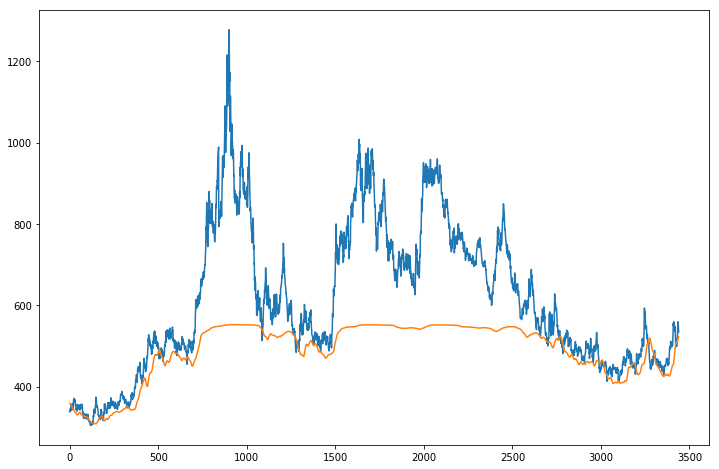

In [407]:
yPred_norm = modelLSTM_F.predict(XTestF)
yPred_denorm = denormalize(yPred_norm)
yTestF_denorm = denormalize(yTestF.reshape(-1,1))

plt.figure(figsize=(12,8))
plt.plot(list(range(len(yTestF))), yTestF_denorm)
plt.plot(list(range(len(yTestF))), yPred_denorm);

# Prediction vs Actual: LSTM - Futures only (data truncated to length of weather data)

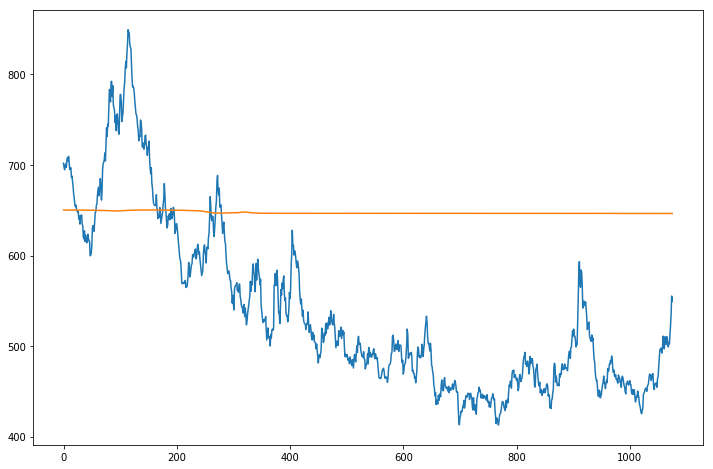

In [408]:
yPred_norm = modelLSTM_FW_F.predict(XTestFW_F)
yPred_denorm = denormalize(yPred_norm)
yTestFW_F_denorm = denormalize(yTestFW_F.reshape(-1,1))

plt.figure(figsize=(12,8))
plt.plot(list(range(len(yTestFW_F))), yTestFW_F_denorm, label='actual')
plt.plot(list(range(len(yTestFW_F))), yPred_denorm, label='prediction');

# Prediction vs Actual: RNN - FUT+Weather

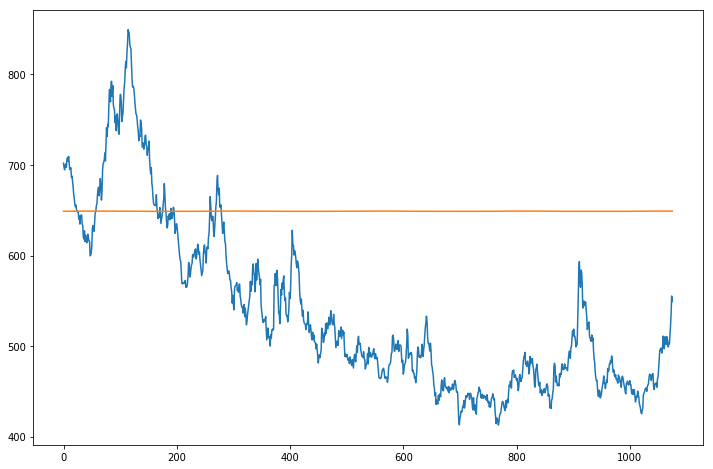

In [409]:
yPredFW_norm = modelRNN_FW.predict(XTestFW)
yPredFW_denorm = denormalize(yPredFW_norm)
yTestFW_denorm = denormalize(yTestFW.reshape(-1,1))

plt.figure(figsize=(12,8))
plt.plot(list(range(len(yTestFW))), yTestFW_denorm)
plt.plot(list(range(len(yTestFW))), yPredFW_denorm);

# Prediction vs Actual: LSTM - Futures only (truncated to length of stock data)

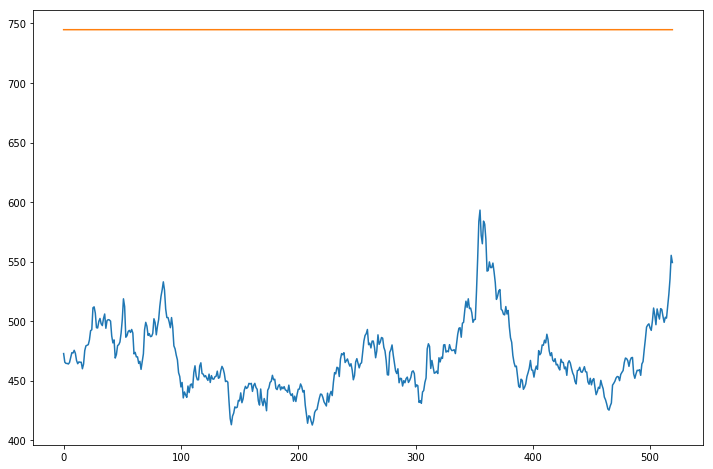

In [410]:
yPredFSW_norm = modelLSTM_FSW_F.predict(XTestFSW_F)
yPredFSW_denorm = denormalize(yPredFSW_norm)
yTestFSW_denorm = denormalize(yTestFSW_F.reshape(-1,1))

plt.figure(figsize=(12,8))
plt.plot(list(range(len(yTestFSW))), yTestFSW_denorm)
plt.plot(list(range(len(yTestFSW))), yPredFSW_denorm);